## Home credit risk analysis is a kaggle competition 

Description:-

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

It contain following tables structure in database

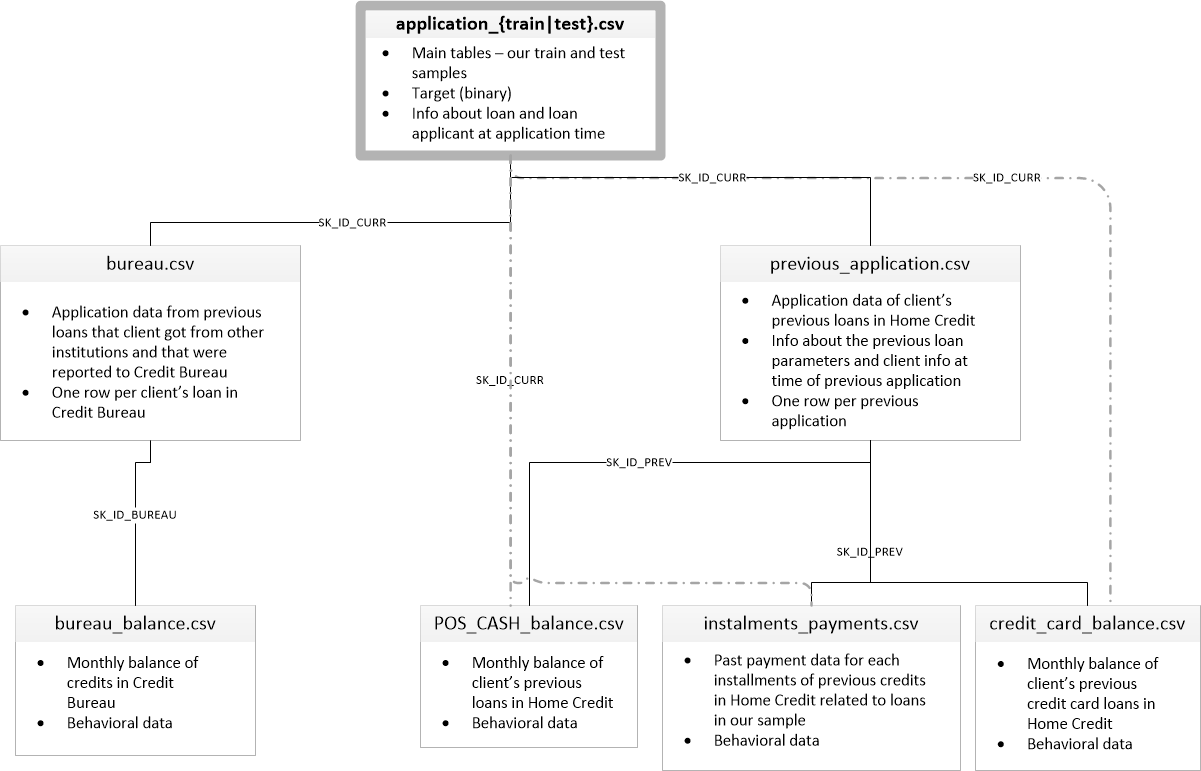

In [1]:
#importing Library
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def one_hot_encoder(dataframe, nan_as_category = True):
    df_numeric_data =dataframe.select_dtypes(include=["number"])
    df_categorical_data = pd.get_dummies(dataframe.select_dtypes(exclude = ["number"]), dummy_na = nan_as_category)
    df = pd.concat([df_numeric_data, df_categorical_data], axis = 1)
    return df, df_categorical_data.columns


In [3]:
num_rows = None
train_df = pd.read_csv('../input/application_train.csv', nrows= num_rows)
test_df = pd.read_csv('../input/application_test.csv', nrows= num_rows)
print("Train shape: {}, test samples: {}".format(train_df.shape, test_df.shape))

Train shape: (307511, 122), test samples: (48744, 121)


In [4]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


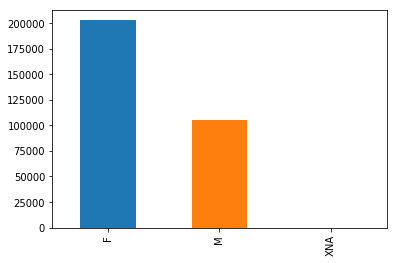

In [5]:
#Plotting Male and Female Counts
train_df['CODE_GENDER'].value_counts().plot(kind='bar')

In [6]:
# Removing XNA from Gender
train_df = train_df[train_df['CODE_GENDER'] != 'XNA']
test_df = test_df[test_df['CODE_GENDER'] != 'XNA']

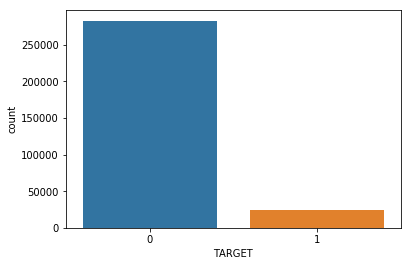

In [7]:
# plotting target as you can see data is lot biased
sns.countplot(train_df.TARGET)

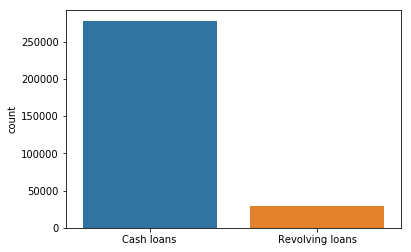

In [8]:
# Plotting type of contract
sns.countplot(train_df.NAME_CONTRACT_TYPE.values)

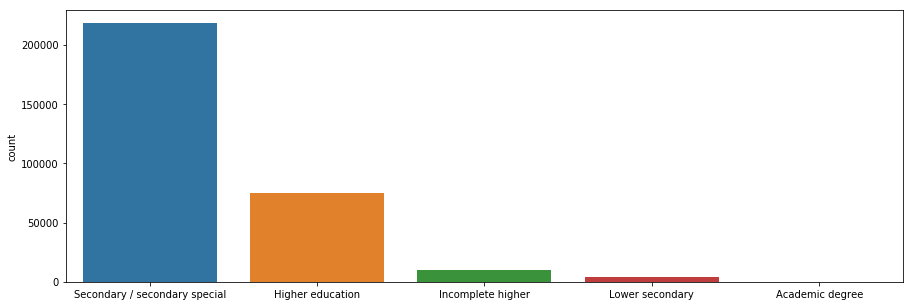

In [9]:
# Plotting education of applicant
plt.figure(figsize=(15,5))
sns.countplot(train_df.NAME_EDUCATION_TYPE.values)
plt.show() #to check what are the differnet categories and their count.

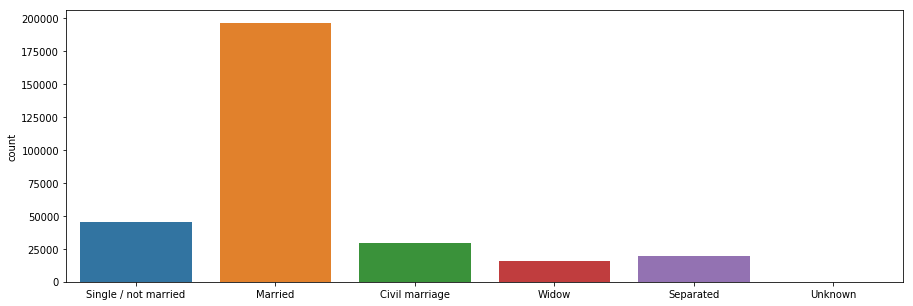

In [10]:
# plotting family status of applicants
plt.figure(figsize=(15,5))
sns.countplot(train_df.NAME_FAMILY_STATUS.values)
plt.show()

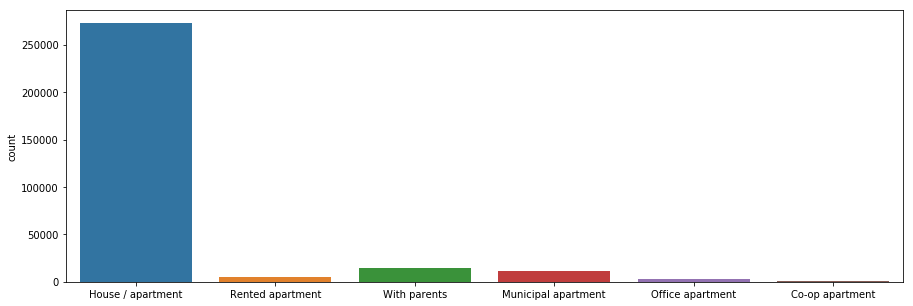

In [11]:
# plotting house condition of applicants
plt.figure(figsize=(15,5))
sns.countplot(train_df.NAME_HOUSING_TYPE.values)
plt.show()

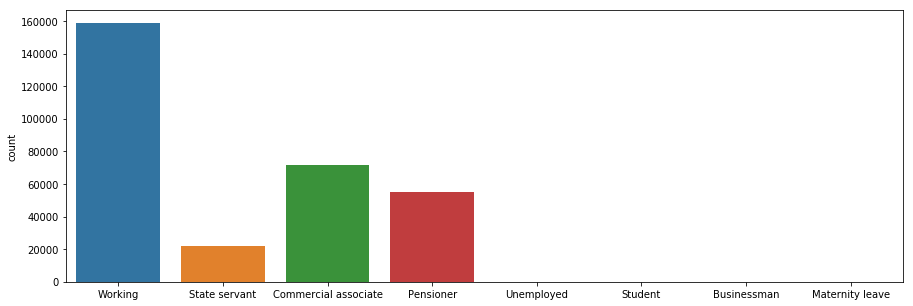

In [12]:
# plotting main source of income of applicants
plt.figure(figsize=(15,5))
sns.countplot(train_df.NAME_INCOME_TYPE.values)
plt.show()

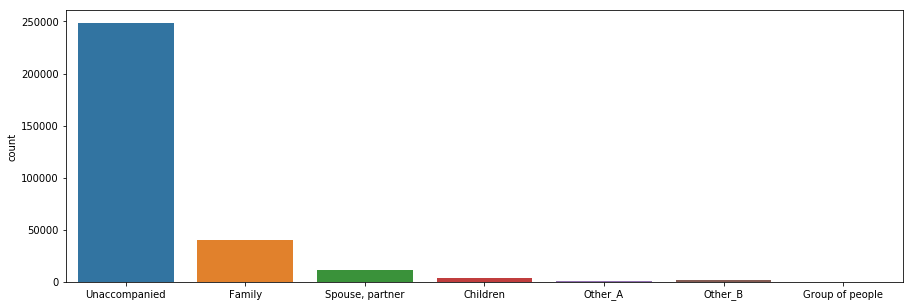

In [13]:
# plotting suite type of applicants
plt.figure(figsize=(15,5))
sns.countplot(train_df.NAME_TYPE_SUITE.values)
plt.show()

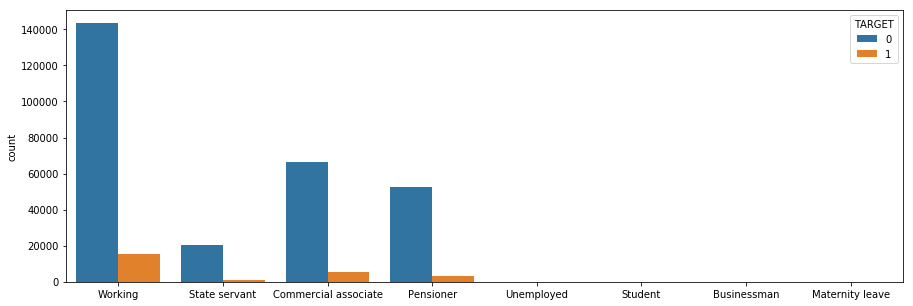

In [14]:
# plotting income type along with associated income of applicants
plt.figure(figsize=(15,5))
sns.countplot(train_df.NAME_INCOME_TYPE.values,hue=train_df.TARGET)
plt.show()

In [15]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Use Binary Label Encoding for features

In [16]:
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    train_df[bin_feature], uniques = pd.factorize(train_df[bin_feature])
    test_df[bin_feature], uniques = pd.factorize(test_df[bin_feature])

## Use One-Hot Encoding

In [17]:
nan_as_category = True
train_df, categorical_col_name_train = one_hot_encoder(train_df, nan_as_category)
test_df, categorical_col_name_test = one_hot_encoder(test_df, nan_as_category)

In [18]:
train_df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,...,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,FONDKAPREMONT_MODE_nan,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,HOUSETYPE_MODE_nan,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


In [19]:
# adding some new features'
# Some simple new features (percentages)
def addingNewFeature(df):
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    return df

train_df = addingNewFeature(train_df)
test_df =  addingNewFeature(test_df)

## Preprocessing Bureau & Bureau Balance Data

In [20]:
nan_as_category = False
bureau = pd.read_csv('../input/bureau.csv')
bureau_balance = pd.read_csv('../input/bureau_balance.csv')
bureau_balance, bureau_balance_col = one_hot_encoder(bureau_balance, nan_as_category)
bureau, bureau_col = one_hot_encoder(bureau, nan_as_category)

## Perform aggregations on bureau balance and merge with bureau.csv

In [21]:
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bureau_balance_col:
    bb_aggregations[col] = ['mean']
bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
del bureau_balance, bb_agg
gc.collect()

98

In [22]:
# extracting num aggregation manually
num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }

## We will repeat this for all other table

1) seperate numberical and categorical <br>
2) Perform some kind of aggregation on each table <br>
3) Combined both numberical and categorical dataframe with each other 

## Bureau and bureau_balance categorical features

In [23]:
# extracting categorical data from bureau and bureau_balance
cat_aggregations = {}
for cat in bureau_col: cat_aggregations[cat] = ['mean']
for cat in bureau_balance_col: cat_aggregations[cat + "_MEAN"] = ['mean']

In [24]:
# performing aggregate operation
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

## using only numerical aggregations on Bureau data

In [25]:
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()

35

## Preprocess previous_applications.csv

In [26]:
prev = pd.read_csv('../input/previous_application.csv')
prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)

In [27]:
prev.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,NAME_CONTRACT_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,FLAG_LAST_APPL_PER_CONTRACT_nan,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,...,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,CHANNEL_TYPE_nan,NAME_SELLER_INDUSTRY_Auto technology,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectivity,NAME_SELLER_INDUSTRY_Construction,NAME_SELLER_INDUSTRY_Consumer electronics,NAME_SELLER_INDUSTRY_Furniture,NAME_SELLER_INDUSTRY_Industry,NAME_SELLER_INDUSTRY_Jewelry,NAME_SELLER_INDUSTRY_MLM partners,NAME_SELLER_INDUSTRY_Tourism,NAME_SELLER_INDUSTRY_XNA,NAME_SELLER_INDUSTRY_nan,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,NAME_YIELD_GROUP_nan,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,5951.000000,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1670214.0,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1670214.0,1.670214e+06,1.670214e+06,1670214.0,1.670214e+06,1.670214e+06,1.670214e+06,...,1.670214e+06,1.670214e+06,1.670214e+06,1670214.0,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1670214.0,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1670214.0,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06,1.670214e+06
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,0.188357,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570,4.475792e-01,4.365614e-01,1.156522e-01,2.071591e-04,0.0,1.509076e-01,1.518111e-01,1.440720e-01,9.864065e-02,1.491420e-01,1.527457e-01,1.526810e-01,0.0,5.074200e-03,9.949258e-01,0.0,1.612368e-03,2.550571e-04,8.142669e-05,...,4.310633e-01,6.497850e-02,1.269795e-01,0.0,2.987641e-03,1.433888e-02,1.652656e-01,1.783065e-02,2.384515e

we observe that there contain some outliners so We will just update Days 365.243 values to  nan

In [28]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

##  Adding feature value ask / value received percentage

In [29]:
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

## Extracting Previous applications numeric features

In [30]:
# done this manually
num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }

## Extracting Previous applications categorical features

In [31]:

cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

In [32]:
prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

## Previous Applications: Approved Applications - only numerical features

In [33]:
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

## Extracting only numerical features from previous application

In [34]:

refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
del refused, refused_agg, approved, approved_agg, prev
gc.collect()


113

## Preprocessing POS_CASH_balance.csv

In [35]:
pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)

In [36]:
# Features aggregation
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

In [37]:
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

In [38]:
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

In [39]:
del pos
gc.collect()

98

## Preprocessing installments_payments.csv

In [40]:
ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
original_columns = list(ins.columns)
categorical_columns = [col for col in ins.columns if ins[col].dtype == 'object']
ins = pd.get_dummies(ins, columns= categorical_columns)
ins_col = [c for c in ins.columns if c not in original_columns]

In [41]:
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']


In [42]:
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

In [43]:
ins['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

In [44]:
ins.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PAYMENT_PERC,PAYMENT_DIFF,DPD,DBD,INSTAL_COUNT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,1.000000,0.000,0.0,7.0,NaN
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525,1.000000,0.000,0.0,0.0,NaN
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000,1.000000,0.000,0.0,0.0,NaN
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130,1.000000,0.000,0.0,8.0,NaN
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585,0.997942,4.455,17.0,0.0,NaN


## Preprocess credit_card_balance.csv

In [45]:
creditBalance = pd.read_csv('../input/credit_card_balance.csv', nrows = num_rows)
creditBalance, cat_cols = one_hot_encoder(creditBalance, nan_as_category= True)

In [46]:
# General aggregations
creditBalance.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = creditBalance.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

In [47]:
# Count credit card lines
cc_agg['CC_COUNT'] = creditBalance.groupby('SK_ID_CURR').size()

## Combining all dataframe 

1) combine all table created above using primary key

In [48]:
train_df = train_df.join(bureau_agg, how='left', on='SK_ID_CURR')
test_df = test_df.join(bureau_agg, how='left', on='SK_ID_CURR')
del bureau_agg


In [49]:
train_df = train_df.join(prev_agg, how='left', on='SK_ID_CURR')
test_df = test_df.join(prev_agg, how='left', on='SK_ID_CURR')
del prev_agg

In [50]:
train_df = train_df.join(pos_agg, how='left', on='SK_ID_CURR')
test_df = test_df.join(pos_agg, how='left', on='SK_ID_CURR')
del pos_agg

In [51]:
train_df = train_df.join(cc_agg, how='left', on='SK_ID_CURR')
test_df = test_df.join(cc_agg, how='left', on='SK_ID_CURR')
del cc_agg

In [52]:
#train_df.to_csv('train.csv')
#test_df.to_csv('test.csv')
gc.collect()

84

## using machine learning model 

In [53]:
target = train_df['TARGET']
del train_df['TARGET']

## Dropping all Column with 60% empty value in both train and test

In [54]:
null_counts = train_df.isnull().sum()
null_counts = null_counts[null_counts > 0]
null_ratios = null_counts / len(train_df)

# Drop columns over x% null
null_thresh = .6
null_cols = null_ratios[null_ratios > null_thresh].index
train_df.drop(null_cols, axis=1, inplace=True)
print('Columns dropped for being over {}% null:'.format(100*null_thresh))
test_df.drop(null_cols, axis=1, inplace=True)

train_df.drop('SK_ID_CURR',axis = 1,inplace = True)
test_df.drop('SK_ID_CURR',axis = 1,inplace = True)

train_df = train_df[test_df.columns]

Columns dropped for being over 60.0% null:


In [55]:
train_df[train_df==np.inf]=np.nan
train_df.fillna(train_df.mean(), inplace=True)

In [56]:
test_df[test_df==np.inf]=np.nan
test_df.fillna(test_df.mean(), inplace=True)

## Using Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=0, class_weight='balanced', C=100)
logreg.fit(train_df, target)


In [ ]:
pred_test = logreg.predict_proba(test_df)
#print("ROC",  roc_auc_score(Y_test, pred_test))
submission = pd.read_csv('../input/sample_submission.csv')

submission['SK_ID_CURR']=app_test['SK_ID_CURR']
print(len(app_test['SK_ID_CURR']))
submission['TARGET']=pred_test
#converting to csv
#print(submission['TARGET'])

submission.to_csv('logisticRegression.csv',index = False)

## Using Random Forest Classifer

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Train on the training data
rf_model = RandomForestClassifier(n_estimators=200, 
                                      min_samples_split=10, 
                                      min_samples_leaf=5, 
                                      n_jobs=-1, 
                                      random_state=42) 
rf_model.fit(train_df, target)


In [ ]:
sub = pd.read_csv('../input/sample_submission.csv')
y_pred = rf_model.predict(test_df)
sub['TARGET'] = y_pred
sub.to_csv('rfprediction.csv',index = False)

## using LightGBM model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, target, test_size=0.33, random_state=42)


In [ ]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [ ]:
params = {
        'task': 'train',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.02,      
        'max_depth': 8,             
        'min_data_in_leaf': 40,      
        'max_bin' : 100,           
        'num_leaves' : 12,         
        'num_iteration': 500,      
        'nthread' :4,
        'n_estimators':10000,
        'num_leaves':34,
        'silent':-1
}
   

In [ ]:
import warnings
warnings.filterwarnings('ignore')
gbm = lgb.train(params,
            lgb_train,
            num_boost_round=100,      
            early_stopping_rounds=10, 
            valid_sets=[lgb_train,lgb_eval],
            valid_names=['train', 'eval'])

In [ ]:
y_pred=gbm.predict(X_test)
pred = np.round(y_pred)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

In [ ]:
sub = pd.read_csv('../input/sample_submission.csv')
y_pred = gbm.predict(test_df)
sub['TARGET'] = y_pred
sub.to_csv('gbmprediction.csv',index = False)

In [ ]:
del gbm
gc.collect()

## Using smote to balance target 

In [ ]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_train_smote, y_train_smote = smt.fit_sample(train_df, target)

In [ ]:
print(train_df.shape)
print(X_train_smote.shape)

## Using RandomForest Classifier based on smote data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Train on the training data
rf_model = RandomForestClassifier(n_estimators=150, 
                                      min_samples_split=10, 
                                      min_samples_leaf=5, 
                                      n_jobs=-1, 
                                      random_state=42) 

rf_model.fit(X_train_smote, y_train_smote)


In [ ]:
sub = pd.read_csv('../input/sample_submission.csv')
y_pred = rf_model.predict(test_df)
sub['TARGET'] = y_pred
sub.to_csv('rfprediction_smote.csv',index = False)

In [57]:
# Testing data accuracy
data = [['Logistic Regression', 0.62710], ['Random Forest', 0.612234], ['Random Forest Smote data', 0.623256], ['Light GBM',0.75199]] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Model', 'Accuracy']) 
  
# print dataframe. 
df

,Model,Accuracy
0,Logistic Regression,0.627100
1,Random Forest,0.612234
2,Random Forest Smote data,0.623256
3,Light GBM,0.751990
